# Exercise 2

Assume the aperture requires a beam size $10\ \sigma<31.4$ mm. Start with the lattice from Exercise 1 and modify it so that the $\beta_{max}$ satisfies this requirement (please use rounded numbers for convenience). The normalized beam emittance is $\epsilon_n = 2.0\ \mu$m. The circumference and the energy must not be changed, all other parameters may be modified.

In [1]:
import numpy as np #NOTE: NAFFLIB requires downgrade of numpy version. Use pip install numpy==2.0.2
import matplotlib.pyplot as plt
import pandas as pd
import xobjects as xo
import xtrack as xt
import scipy

How can we change $\beta_{max}$?

/tmp/ipykernel_242272/1763640012.py:9: RuntimeWarning: invalid value encountered in sqrt
  return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)
/tmp/ipykernel_242272/1763640012.py:9: RuntimeWarning: divide by zero encountered in divide
  return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)


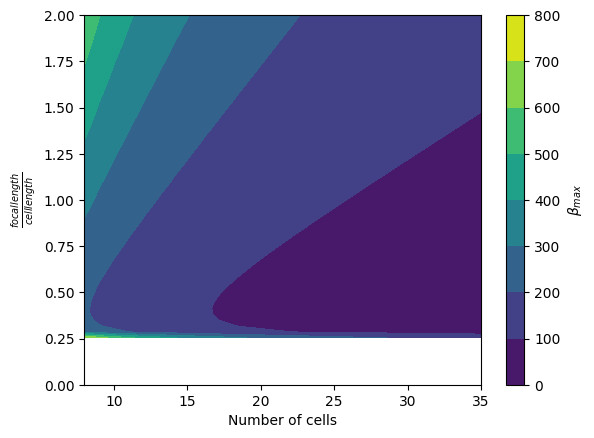

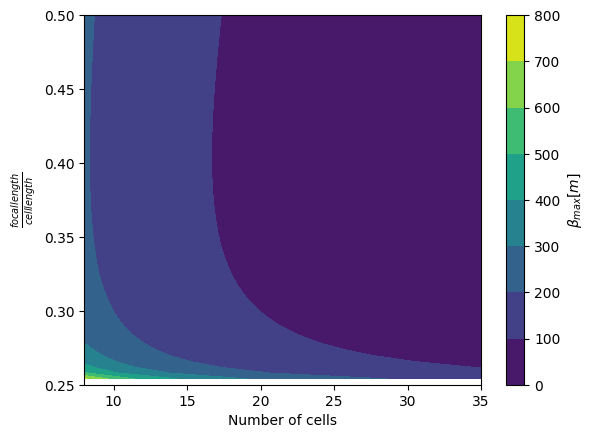

In [2]:
flr = np.linspace(0.00, 2, 64)
ns = np.linspace(8,35, 35-8)

circ = 1000


def fun(flr, L):
    f = flr*L    
    return 2*f*np.sqrt(4*f+L)/np.sqrt(4*f-L)
    
fin, nin = np.meshgrid(flr, ns)

plt.figure()
plt.contourf(ns, flr, fun(fin, circ/nin).T)
plt.ylabel(r'$\frac{focal length}{cell length}$')
plt.xlabel('Number of cells')
plt.colorbar(label = r'$\beta_{max}$')

plt.figure()
flr = np.linspace(0.25, 0.5, 64)
fin, nin = np.meshgrid(flr, ns)

plt.contourf(ns, flr, fun(fin, circ/nin).T)
plt.ylabel(r'$\frac{focal length}{cell length}$')
plt.xlabel('Number of cells')
plt.colorbar(label = r'$\beta_{max} [m]$')

## Define new version of the lattice
Here we increase the number of cells to achieve the reduced $\beta_{max}$.

In [3]:
lcirc = 1000.0
lquad = 3.0
lbend = 5.0
max_dipole_field = 3.0
number_of_FODO = 20
number_of_dipoles = 4*number_of_FODO
k1 = 0.0098
pc_GeV = 20.0
lFODO = lcirc/number_of_FODO

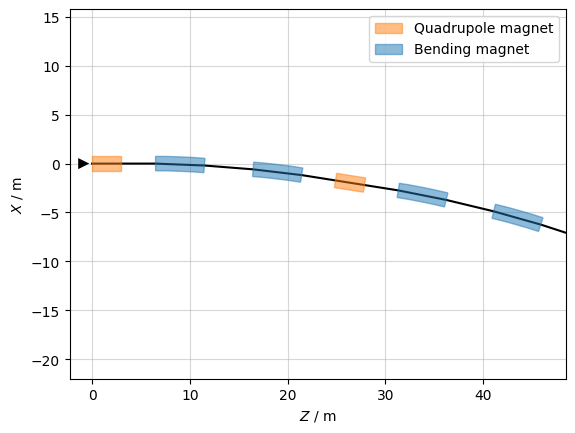

In [4]:
env = xt.Environment()
env.vars({'lcirc': lcirc,
          'lquad': lquad, 
          'lbend': lbend, 
          'k1f': k1, 
          'k1d': -k1,
          'number_of_dipoles': number_of_dipoles,
          'angle.mb': 2.0*np.pi/number_of_dipoles,
          'k0.mb': 'angle.mb/lbend',
          'number_of_fodo': number_of_FODO,
          'lfodo': 'lcirc/number_of_fodo'
          })

env.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)

env.new('mb', xt.Bend, length='lbend', k0='k0.mb', h='k0.mb')
env.new('mq', xt.Quadrupole, length='lquad')


env.new('mb.0', 'mb')
env.new('mb.1', 'mb')
env.new('mb.2', 'mb')
env.new('mb.3', 'mb')

env.new('mq.f', 'mq', k1='k1f')
env.new('mq.d', 'mq', k1='k1d')

cell = env.new_line(components=[
    env.place('mq.f', at=lquad*0.5),
    env.place('mb.0', at='0.15 * lfodo + lquad * 0.5'),
    env.place('mb.1', at='0.35 * lfodo  + lquad*0.5'),
    env.place('mq.d', at='0.50 * lfodo + lquad*0.5'),
    env.place('mb.2', at='0.65 * lfodo + lquad*0.5'),
    env.place('mb.3', at='0.85 * lfodo + lquad*0.5'),
    env.new('marker_end', xt.Marker, at='lfodo'),

])

#verify cell looks sensible
cell.survey().plot()

In [5]:
cell.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Quadrupole,mq.f,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
1,3.0,Drift,drift_1,True,False,None,False,Drift(length=3.5)
2,6.5,Bend,mb.0,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
3,11.5,Drift,drift_2,True,False,None,False,Drift(length=5)
4,16.5,Bend,mb.1,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
5,21.5,Drift,drift_3,True,False,None,False,Drift(length=3.5)
6,25.0,Quadrupole,mq.d,True,False,None,False,"Quadrupole(k1=-0.0098, k1s=0, length=3, num_mu..."
7,28.0,Drift,drift_4,True,False,None,False,Drift(length=3.5)
8,31.5,Bend,mb.2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
9,36.5,Drift,drift_5,True,False,None,False,Drift(length=5)


In [6]:

cells = []
for i in range(number_of_FODO):
    cells.append(env.new('cell_{}'.format(i), cell))


#%% append in cells number_of_FODO times cell
line = env.new_line(components=[env.new('_start_point', xt.Marker)]+cells)

line.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.f.cell_0,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_1.cell_0,True,False,None,False,Drift(length=3.5)
3,6.5,Bend,mb.0.cell_0,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
4,11.5,Drift,drift_2.cell_0,True,False,None,False,Drift(length=5)
...,...,...,...,...,...,...,...,...
257,986.5,Drift,drift_5.cell_19,True,False,None,False,Drift(length=5)
258,991.5,Bend,mb.3.cell_19,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
259,996.5,Drift,drift_6.cell_19,True,False,None,False,Drift(length=3.5)
260,1000.0,Marker,marker_end.cell_19,False,False,None,False,Marker(_dummy=np.int64(0))


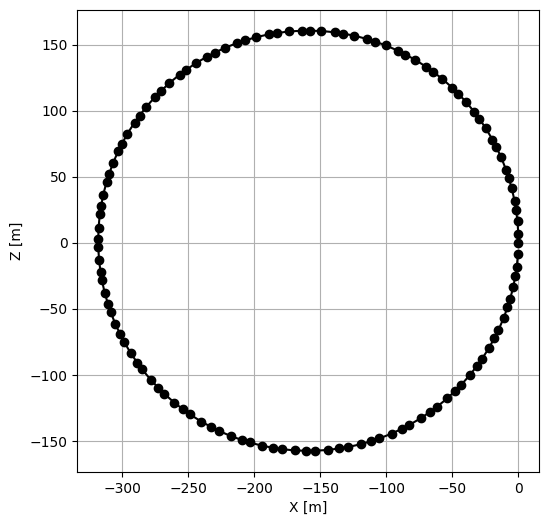

In [7]:
# 2. Definition of the beam
line.particle_ref = xt.Particles(p0c=20e9, #eV
                                 q0=1, mass0=xt.PROTON_MASS_EV)
# %%
context = xo.ContextCpu()
line.build_tracker(_context=context)

#%%
mySurvey = line.survey()
mySurvey = mySurvey.rows[r'^(mq|mb).*']
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(mySurvey.X, mySurvey.Z, 'o-', label="x", c="k")
plt.axis('square')
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()
# %%
myTwiss= line.twiss(method='4d')

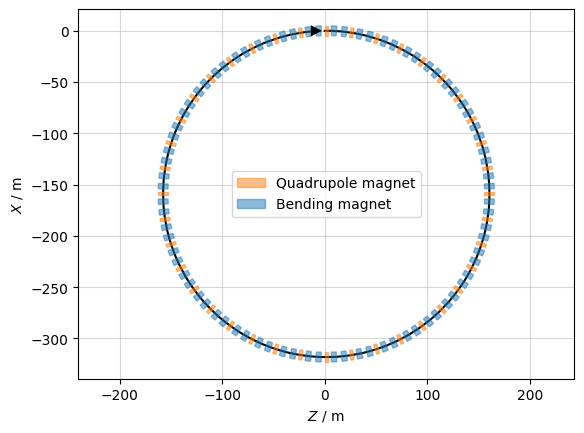

In [8]:
mySurvey.plot()

## Inspect Twiss/Courant-Snyder parameters of lattice

(-0.05, 0.05)

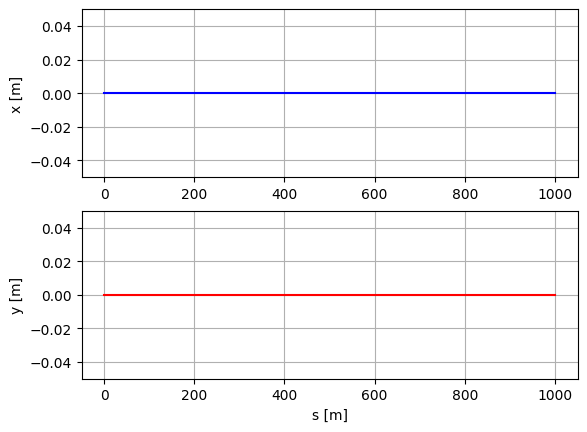

In [9]:
# The closed orbit corresponds in this case to the reference orbit
plt.subplot(211)
plt.plot(myTwiss.s,myTwiss.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()
plt.ylim(-0.05,0.05)

plt.subplot(212)
plt.plot(myTwiss.s,myTwiss.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()
plt.ylim(-0.05,0.05)

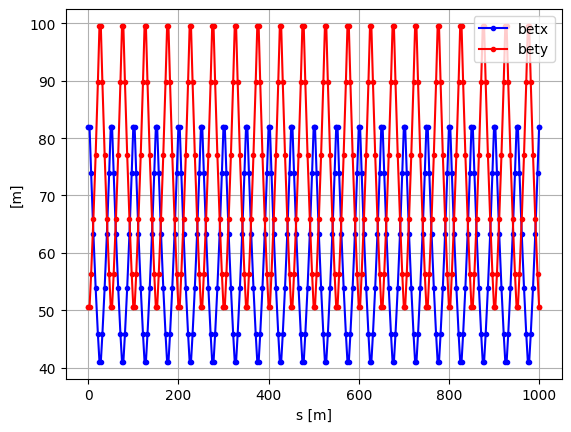

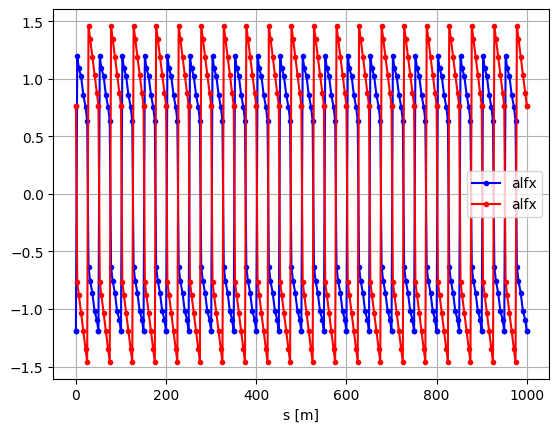

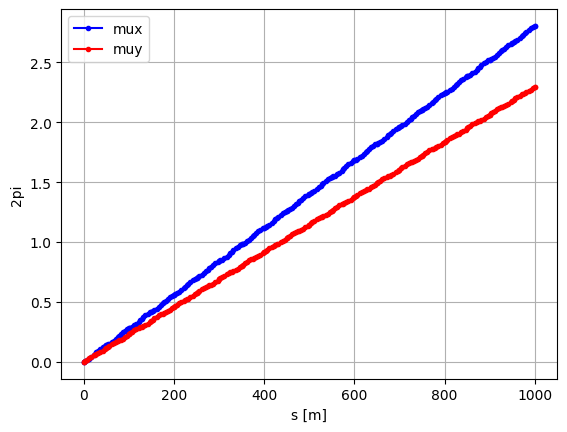

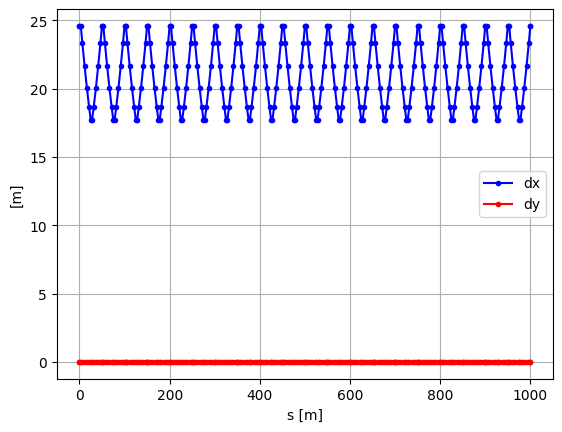

In [10]:
def plot_me(myTwiss):
    plt.plot(myTwiss.s,myTwiss.betx,'.-b', label='betx')
    plt.plot(myTwiss.s,myTwiss.bety,'.-r', label='bety')
    plt.ylabel('[m]')
    plt.xlabel('s [m]')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.alfx,'.-b', label='alfx')
    plt.plot(myTwiss.s,myTwiss.alfy,'.-r', label='alfx')
    plt.xlabel('s [m]')
    plt.ylabel('')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.mux,'.-b', label='mux')
    plt.plot(myTwiss.s,myTwiss.muy,'.-r', label='muy')
    plt.xlabel('s [m]')
    plt.ylabel('2pi')
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(myTwiss.s,myTwiss.dx,'.-b', label='dx')
    plt.plot(myTwiss.s,myTwiss.dy,'.-r', label='dy')
    plt.xlabel('s [m]')
    plt.ylabel('[m]')
    plt.grid()
    plt.legend()
plot_me(myTwiss)

### Can we inject a dipolar error to the machine to see something more interesting?

To do this we create a thin xt.Multipole element with a defined dipole coefficient. We make a copy of our original line and use the line.insert_element method to install the thin dipole kick into the line. 

In [11]:
env.vars['kick_strength'] = 0.0002
kick = env.new('kick', xt.Multipole, knl = ['kick_strength'], length = 0, order = 0)
line2 = env.new('line2', line)
line2.insert_element(kick, at = "mq.f.cell_0.line2")
line2.to_pandas()

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point.line2,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Multipole,kick,False,False,None,False,"Multipole(_order=np.int64(0), inv_factorial_or..."
2,0.0,Quadrupole,mq.f.cell_0.line2,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
3,3.0,Drift,drift_1.cell_0.line2,True,False,None,False,Drift(length=3.5)
4,6.5,Bend,mb.0.cell_0.line2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
...,...,...,...,...,...,...,...,...
258,986.5,Drift,drift_5.cell_19.line2,True,False,None,False,Drift(length=5)
259,991.5,Bend,mb.3.cell_19.line2,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
260,996.5,Drift,drift_6.cell_19.line2,True,False,None,False,Drift(length=3.5)
261,1000.0,Marker,marker_end.cell_19.line2,False,False,None,False,Marker(_dummy=np.int64(0))


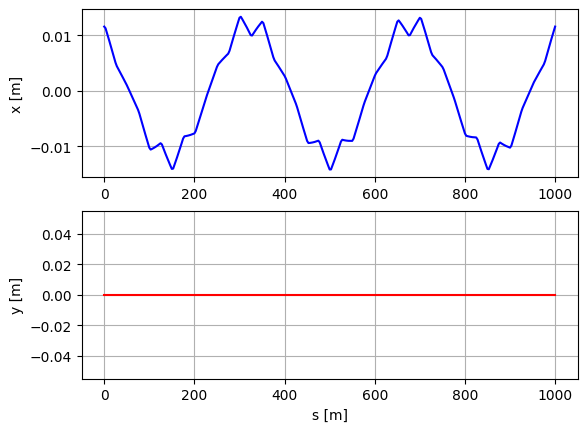

In [12]:
myTwissNew = line2.twiss(method = '4d')
plt.subplot(211)
plt.plot(myTwissNew.s,myTwissNew.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwissNew.s,myTwissNew.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()

#plot in normalised coordinates, show discontinuity at kick position

Please compare the previous plot with the closed form formula (see Eq. 9 in pag.55/75 of https://indico.cern.ch/event/1380440/contributions/6176021/attachments/2964454/5215010/IntroductionOpticsDesign.pdf), 
$$x_{CO}(s)=\frac{\sqrt{\beta_x(s)\beta_x(s_0)}}{2 \sin(\pi Q_x) } \theta_0 \cos(\phi - \pi Q_x),$$
where $\phi$ (>0) is the phase advance from $s_0$ (position of the $\theta_0$ kick) to the $s$.

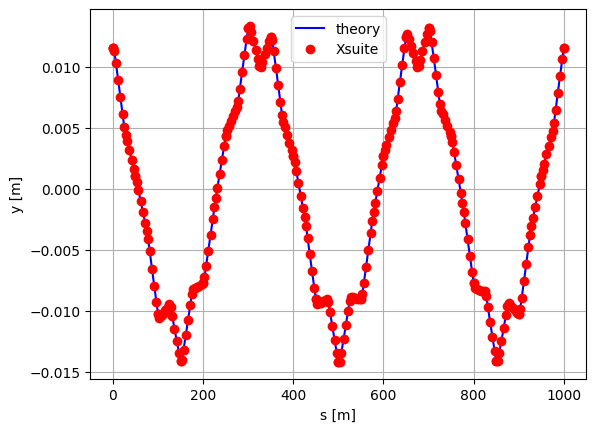

In [13]:
x=-np.sqrt(myTwissNew['betx']*myTwissNew['betx'][0])/2/np.sin(np.pi*myTwissNew['mux'][-1])*0.0002*np.cos(myTwissNew['mux']*2*np.pi-np.pi*myTwissNew['mux'][-1])
plt.plot(myTwissNew['s'],x,'b',label='theory')
plt.plot(myTwissNew['s'],myTwissNew['x'],'or',label='Xsuite')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()
plt.legend(loc='best')

#### What is the dispersive contribution of the kick?

In [14]:
env.vars['kick_strength'] = 0
myTwissRef = line2.twiss(method = '4d')

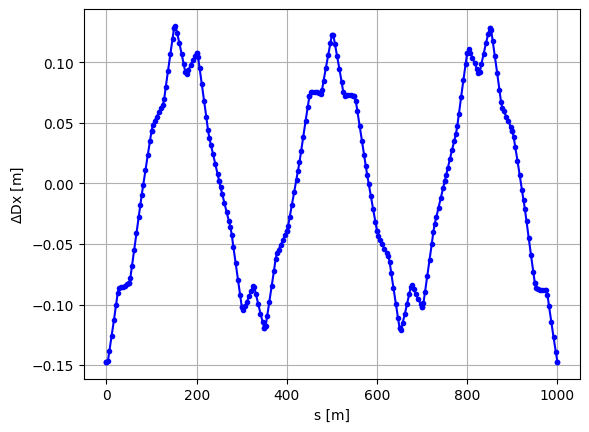

In [15]:
plt.plot(myTwissNew['s'],myTwissNew['dx']-myTwissRef['dx'],'.-b')
plt.xlabel('s [m]')
plt.ylabel(r'$\Delta$Dx [m]')
plt.grid()

### What if the kick is positioned somewhere else?

In [16]:
env.vars['kick_strength'] = 0.0002
line3 = env.new('line3', line)
line3.insert_element(kick, at_s = np.fmod(12097671.72103, line.get_length())) #put a kick in a random place
line3.to_pandas()

Slicing line:   0%|          | 0/261 [00:00<?, ?it/s]

,s,element_type,name,isthick,isreplica,parent_name,iscollective,element
0,0.0,Marker,_start_point.line3,False,False,None,False,Marker(_dummy=np.int64(0))
1,0.0,Quadrupole,mq.f.cell_0.line3,True,False,None,False,"Quadrupole(k1=0.0098, k1s=0, length=3, num_mul..."
2,3.0,Drift,drift_1.cell_0.line3,True,False,None,False,Drift(length=3.5)
3,6.5,Bend,mb.0.cell_0.line3,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
4,11.5,Drift,drift_2.cell_0.line3,True,False,None,False,Drift(length=5)
...,...,...,...,...,...,...,...,...
259,986.5,Drift,drift_5.cell_19.line3,True,False,None,False,Drift(length=5)
260,991.5,Bend,mb.3.cell_19.line3,True,False,None,False,"Bend(length=5, k0=0.0157, k1=0, h=0.0157, mode..."
261,996.5,Drift,drift_6.cell_19.line3,True,False,None,False,Drift(length=3.5)
262,1000.0,Marker,marker_end.cell_19.line3,False,False,None,False,Marker(_dummy=np.int64(0))


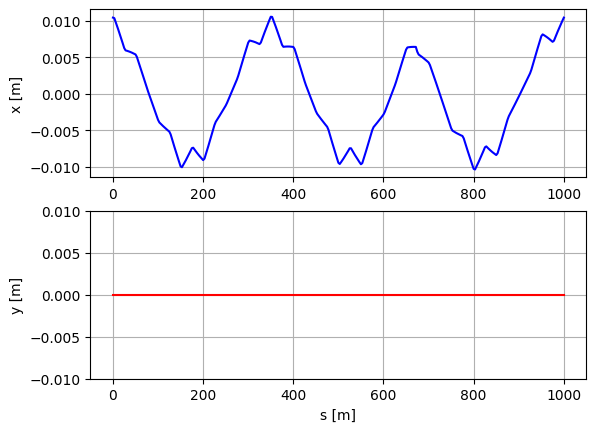

In [17]:
myTwissNew = line3.twiss(method = '4d')
plt.subplot(211)
plt.plot(myTwissNew.s,myTwissNew.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwissNew.s,myTwissNew.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.ylim(-0.01, 0.01)
plt.grid()


Can you tell where the kick is positioned?

Let's try looking at this in normalised space...

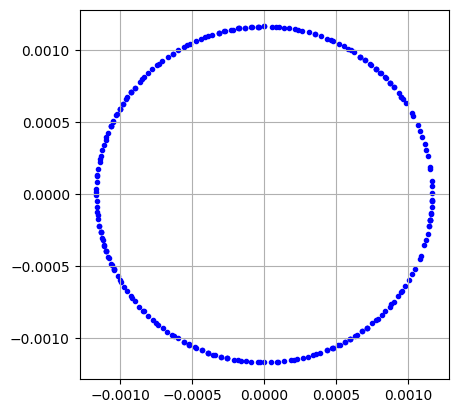

In [18]:
X = np.vstack([myTwissNew.x, myTwissNew.px, myTwissNew.y, myTwissNew.py, myTwissNew.zeta, myTwissNew.delta]).T
Xnorm = []

for i, mat in enumerate(myTwissNew.W_matrix): #use Xsuite's calculation of the W matrix -- this is a powerful tool...
    inv = np.linalg.inv(mat)
    Xnorm.append(inv@X[i])

Xnorm = np.vstack(Xnorm)
plt.scatter(Xnorm[:, 0], Xnorm[:, 1], marker = '.', color = 'b')
plt.grid()
plt.gca().set_aspect('equal')

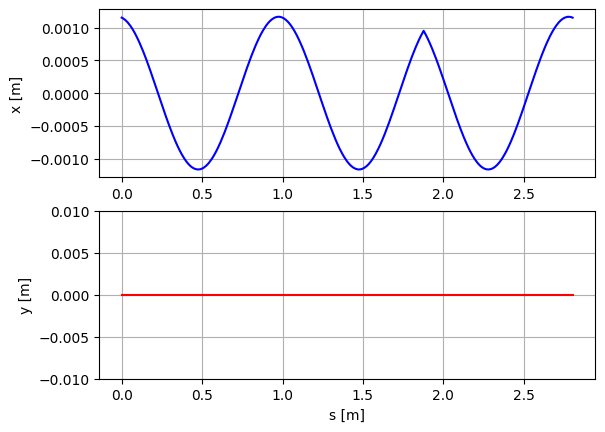

In [19]:
plt.subplot(211)
plt.plot(myTwissNew.mux,Xnorm[:,0],'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwissNew.mux,myTwissNew.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.ylim(-0.01, 0.01)
plt.grid()

## What if we have a coupling error as well?

Go back to our original kick.

In [20]:
env.vars['kick_strength'] = 0.0002
env.vars['kskew'] = 0.0007
env.new('skew_quad', xt.Multipole, ksl = [0, 'kskew'])

'skew_quad'

In [21]:
line2.discard_tracker()
line2.insert_element('skew_quad', index = 'mq.f.cell_0.line2')

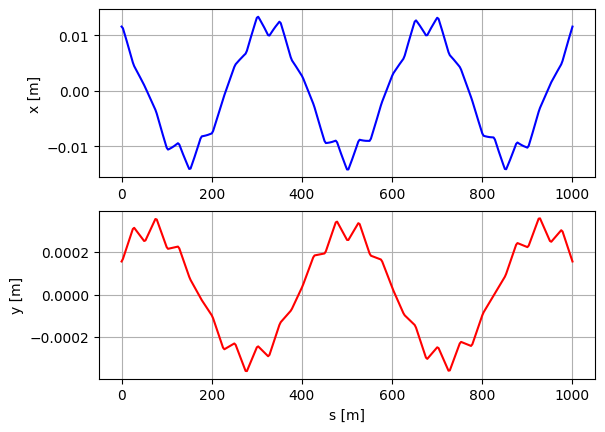

In [22]:
myTwissNew = line2.twiss(method = '4d')
plt.subplot(211)
plt.plot(myTwissNew.s,myTwissNew.x,'b',label='x')
plt.ylabel('x [m]')
plt.grid()

plt.subplot(212)
plt.plot(myTwissNew.s,myTwissNew.y,'r',label='y')
plt.xlabel('s [m]')
plt.ylabel('y [m]')
plt.grid()

In [23]:
twSkew = line2.twiss4d()

The horizontal kick now affects the vertical plane! 

## What is the effect of the skew coupling on our optics?

Let's compute the one-turn map...

In [24]:
rmat = twSkew.get_R_matrix('_start_point.line2', '_end_point')
rmat4 = rmat[:4,:4] #take 4d part only
display(rmat4)

array([[ 1.45891908e+00, -7.73019437e+01, -5.41123278e-02,
        -4.01164686e-05],
       [ 2.79697187e-02, -7.96557956e-01, -5.57586331e-04,
        -8.17731224e-08],
       [ 3.40971325e-02, -4.13962347e-05,  4.71611052e-01,
         4.87085524e+01],
       [-7.05633851e-04,  3.30178490e-07, -3.02904641e-02,
        -1.00804389e+00]])

In introductory accelerator physics courses, it is common to compute the fractional horizontal tune from the trace of the horizontal transfer matrix as $$
q_x = arccos(Tr[M_x])/2\pi
$$

In [25]:
rmat2 = rmat[:2,:2] #take 'horizontal transfer matrix' from 4d map
qx = np.acos(np.trace(rmat2)/2)/(2*np.pi)
qx

np.float64(0.19627653738292505)

However, let us try outputting the horizontal tune directly from the Xsuite Twiss...

In [26]:
np.abs(np.round(twSkew.qx)-twSkew.qx)

np.float64(0.19640648844844222)

These values no longer agree past the third decimal point! Why is this?

What is the meaning of horizontal tune in a coupled system?

In general, the fractional tunes of any periodic system can be computed from the eigenvalues of its transfer matrix. They are given by the argument of the complex eigenvalues normalised by 2pi.

In [27]:
eigtunes = np.angle(np.linalg.eig(rmat4)[0])/np.pi/2
eigtunes

array([ 0.19640649, -0.19640649,  0.29308983, -0.29308983])

This matches the value computed from Xsuite... -- a first taste of coupled dynamics. 

In [28]:
xtunes = [np.abs(twSkew.qx-np.round(twSkew.qx)), np.abs(twSkew.qy-np.round(twSkew.qy))]
xtunes

[np.float64(0.19640648844844222), np.float64(0.2930898286498156)]

## Beam envelope

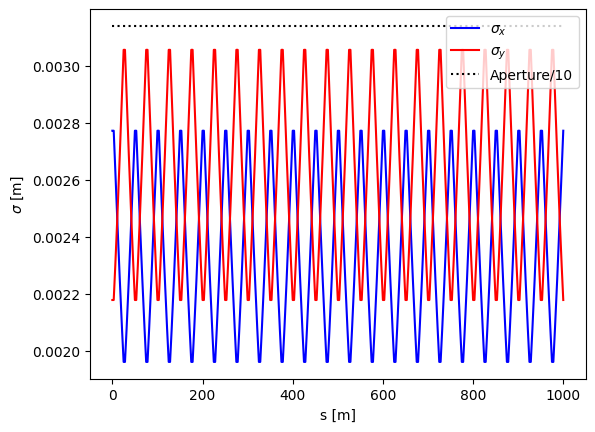

In [29]:
p_GeV_c=20.
E0_GeV=0.938 # approx
Etot_GeV=np.sqrt(p_GeV_c**2+E0_GeV**2)
Ekin_GeV=Etot_GeV-E0_GeV
aperture_limit=0.0314/10; #divide by 10 for 10 sigma limit
emittance_normalized_x=emittance_normalized_y=2.e-6

gamma=Etot_GeV/E0_GeV
beta=np.sqrt(1-1/gamma**2)
betagamma=beta*gamma

myTwiss['sigmax']=np.sqrt(myTwiss.betx*emittance_normalized_x/betagamma)
myTwiss['sigmay']=np.sqrt(myTwiss.bety*emittance_normalized_y/betagamma)

plt.plot(myTwiss.s,myTwiss.sigmax,'b', label = r'$\sigma_x$')
plt.plot(myTwiss.s,myTwiss.sigmay,'r', label = r'$\sigma_y$')

plt.plot(myTwiss.s, myTwiss.s*0+aperture_limit,'k:', label = 'Aperture/10')
plt.xlabel('s [m]')
plt.ylabel(r'$\sigma$ [m]');

plt.legend(loc=1)

## Dispersion contribution to the envelope

Just having a small beta-function is not necessarily sufficient to keep the whole beam in the aperture. We also need to consider the dispersion and how it relates to the momentum spread of the beam: let us assume $\Delta P/P_0 = 10^{-3}$.

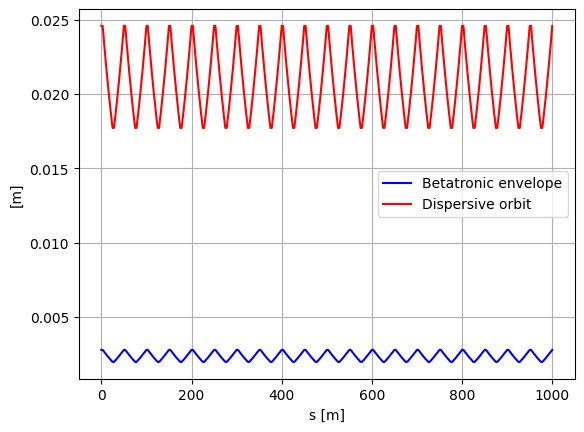

In [30]:
plt.plot(myTwiss.s,myTwiss.sigmax,'b', label='Betatronic envelope')
plt.plot(myTwiss.s,myTwiss.dx*1e-3,'r', label='Dispersive orbit')
plt.xlabel('s [m]')
plt.ylabel('[m]');
plt.grid(True)
plt.legend(loc='best')

## Tracking

Can you compute the particle trajectories if you start particles (at s=0) with offsets on the order of 1 mm?

In [31]:
line.build_tracker() #generate tracker for original line (no dipolar kick!)
particles = line.build_particles(
                        x=[0.001, -0.0008, 0.0005], px = [0.0, -4.0e-6, 6e-6]) #create single particle with 1mm offset from closed orbit

Check the positions of our particles at the start of the line.

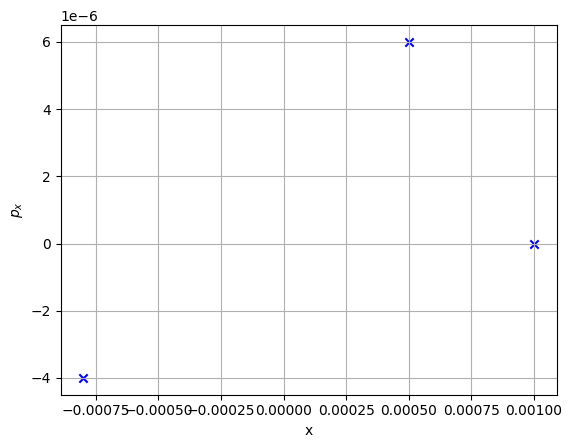

In [32]:
plt.scatter(particles.x, particles. px, marker = 'x', color = 'b')
plt.xlabel('x')
plt.ylabel(r'$p_x$')
plt.grid()

The initial positions of the particles make a triangle. Let's check its area.

In [33]:
def triArea (x, y):
    area = np.abs(0.5*(x[0]*(y[1]-y[2]) + x[1]*(y[2]-y[0]) + x[2]*(y[0]-y[1])))
    return area
A0 = triArea(particles.x, particles.px)
A0

np.float64(6.399999999999999e-09)

Now let's launch these particles through the lattice.

In [34]:
n_turns = 1
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor='ONE_TURN_EBE') #track particle for 1 turn.
#Flag 'ONE_TURN_EBE' tells Xsuite to save particle data at each element for one turn
#Normally 'True' flag saves data once per turn only. 'False' flag does tracking for n_turns without saving intermediate steps

Text(0, 0.5, 'x [m]')

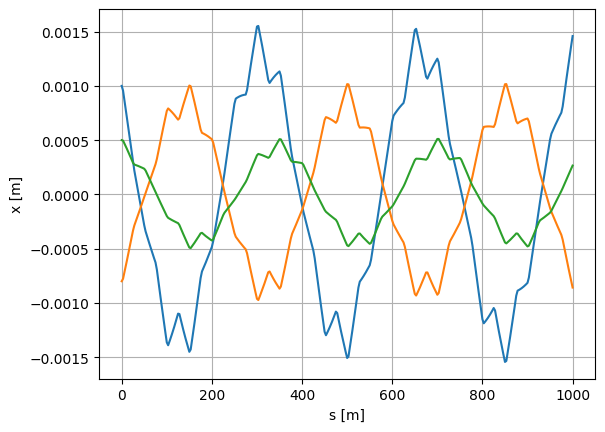

In [35]:
plt.plot(line.record_last_track.s.T, line.record_last_track.x.T)
plt.grid()
plt.xlabel('s [m]')
plt.ylabel('x [m]')

## Courant-Snyder invariant 

The C-S invariant should be constant as we track.

(0.0, 1000.0)

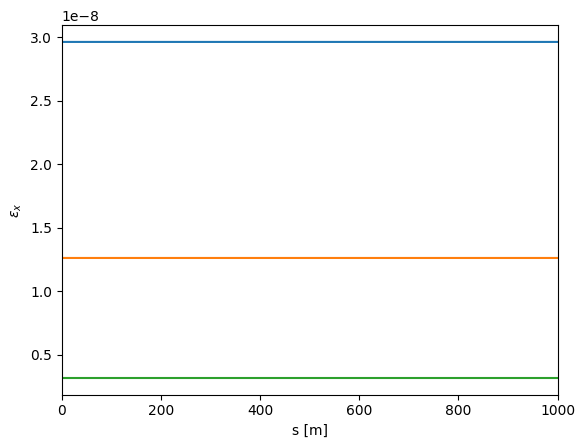

In [36]:
part = line.record_last_track
cs_2d_oneturn = myTwiss.gamx*part.x**2 + 2*myTwiss.alfx*part.px*part.x + myTwiss.betx*part.px**2 #compute invariant
plt.plot(part.s.T, cs_2d_oneturn.T)
plt.ylabel(r'$\epsilon_x$')
plt.xlabel('s [m]')
plt.xlim(0, line.get_length())

As expected, the Courant-Snyder invariant does not change throughout the tracking. 

To really enforce this, let's examine our x-px phase space at a few points along the ring.

Text(0, 0.5, 'px')

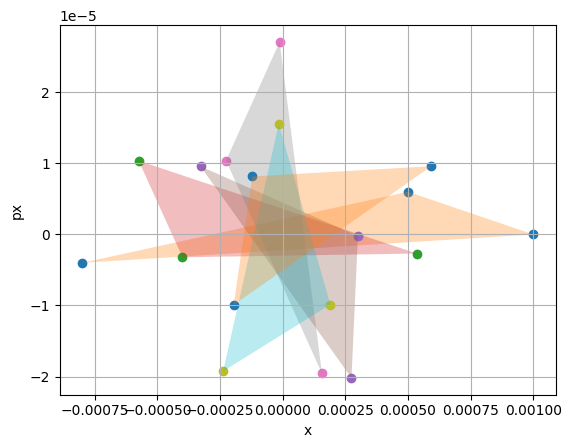

In [37]:
for step in range(line.record_last_track.x[0,:].shape[0]):
    if step%50==0:
        plt.scatter(line.record_last_track.x[:, step], line.record_last_track.px[:,step])
        plt.gca().fill(line.record_last_track.x[:, step], line.record_last_track.px[:, step], alpha=0.3)
plt.grid()
plt.xlabel('x')
plt.ylabel('px')

As you can see, at each point along the ring we can draw a triangle between the three particles. If we compute the area of this triangle...

In [38]:
AS = triArea(line.record_last_track.x, line.record_last_track.px)

Text(0, 0.5, 'Triangle area')

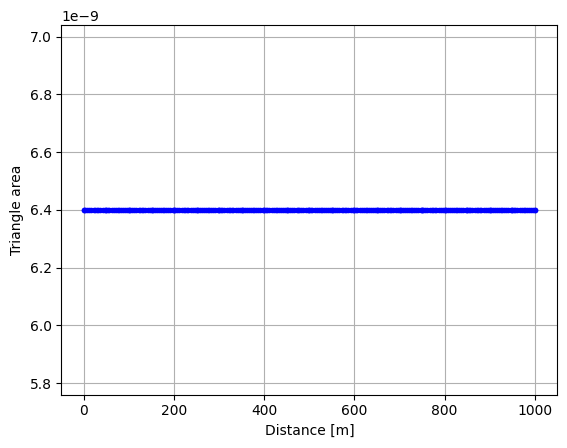

In [39]:
plt.plot(myTwiss.s, triArea(line.record_last_track.x, line.record_last_track.px), '.-b')
plt.grid()
plt.ylim(A0*0.9, A0*1.1)
plt.xlabel('Distance [m]')
plt.ylabel('Triangle area')

We find that it is conserved.

## Can you plot the normalized $x(s)$ vs $\mu_x(s)$?

Remember that $$\bar{P}=\begin{pmatrix}
    \sqrt{\beta} &        0\\\\
    -\frac{\alpha}{\sqrt{\beta}} &  \frac{1}{\sqrt{\beta}} \end{pmatrix}=
    \begin{pmatrix}
    \sqrt{\beta} &        0\\\\
    0 &  \frac{1}{\sqrt{\beta}}
    \end{pmatrix}
    \begin{pmatrix}
    1 &        0\\\\
    \frac{\alpha}{\sqrt{\beta}} &  1
    \end{pmatrix},$$
and that to transform to normalised space $$
    \bar{X}=\bar{P}^{-1} X.$$

In other words, you need to divide $x(s)$ by $\sqrt{\beta(s)}$.

3


(0.0, 2.803744274191341)

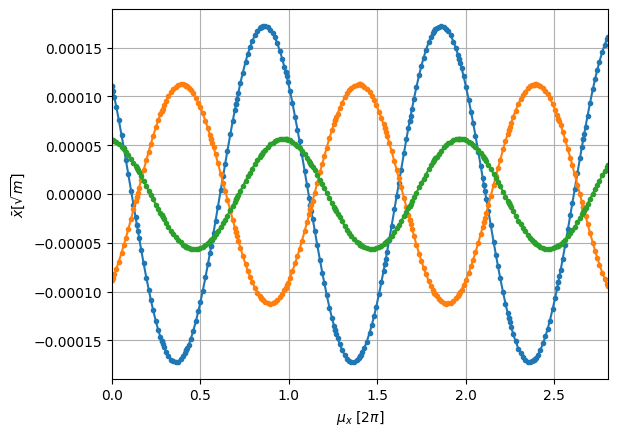

In [40]:
xs = line.record_last_track.x.T
n_parts = xs.shape[1]
print(n_parts)
betxs = np.repeat(myTwiss.betx[:, np.newaxis], n_parts, axis=1)
normx = xs/np.sqrt(betxs)
muxs = np.repeat(normx, xs.shape[1], axis = 1)

plt.plot(myTwiss['mux'],normx,'.-')

plt.grid()
plt.xlabel(r'$\mu_x$ [2$\pi$]')
plt.ylabel(r'$\bar{x}$[$\sqrt{m}$]');
plt.xlim(0,myTwiss.mux[-1])

Particles trace out sinusoidal oscillations in normalised phase space. 

## What about tracking over many turns?

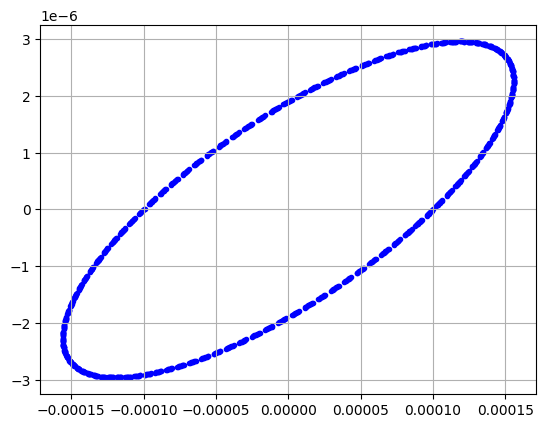

In [41]:
particles = line.build_particles(
                        x=0.0001) #generate single particle

n_turns = 2**10
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True) #track for large number of turns and save position at same point each turn
myParticle = line.record_last_track
plt.scatter(myParticle.x.T, myParticle.px.T, marker = '.', color = 'b') #plot phase space ellipse from tracking over successive turns
plt.grid()

In [42]:
x = myParticle.x.flatten()
px = myParticle.px.flatten()
cs_2d = myTwiss.gamx[0]*x**2 + 2*myTwiss.alfx[0]*px*x + myTwiss.betx[0]*px**2 #we compute once again the invariant

(2.667819672941067e-10, 3.260668489150193e-10)

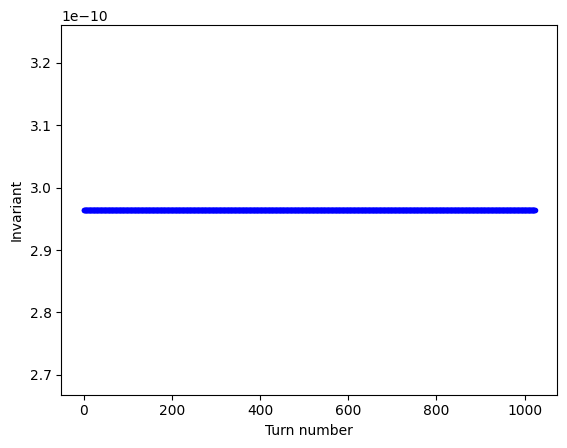

In [43]:
plt.plot(myParticle.at_turn.flatten(), cs_2d, '.-b')
plt.xlabel('Turn number')
plt.ylabel('Invariant')
plt.ylim(cs_2d[0]*0.9, cs_2d[0]*1.1)

Invariant is preserved.

-9.312437570724597e-10
9.312447428459978e-10


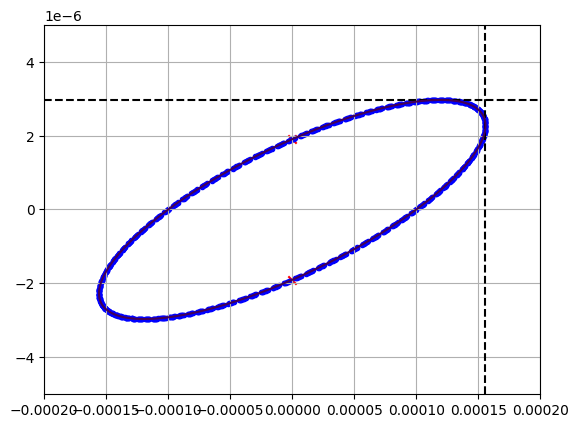

In [44]:
A = np.stack([x**2, x * px, px**2, x, px]).T
b = np.ones_like(x)
w = np.linalg.lstsq(A, b)[0].squeeze() #fit general ellipse of form Ax**2 + Bxy + Cy**2 +Dx *Ey to data

xmin, xmax = -2e-4, 2e-4
pxmin, pxmax = -5e-6, 5e-6

xlin = np.linspace(-2e-4, 2e-4, 300)
pxlin = np.linspace(pxmin, pxmax, 300)
X, PX = np.meshgrid(xlin, pxlin)

Z = w[0]*X**2 + w[1]*X*PX + w[2]*PX**2 + w[3]*X + w[4]*PX #ellipse equation

plt.vlines(np.sqrt(myTwiss.betx[0]*cs_2d[0]), pxmin, pxmax, ls = '--', color = 'k') # we can use the Twiss parameters to describe the beam envelope
plt.hlines(np.sqrt(myTwiss.gamx[0]*cs_2d[0]), xmin, xmax, ls = '--', color = 'k') 

#Area of an ellipse in geometry is given by y intercept * x max * pi
yint =  np.roots([w[2], w[4], -1]) #compute intercept from parameters of fitted ellipse
max_x = np.amax(x) #really we should compute x max from parameters of fit - but that is a big equation and I don't want to write it
area = np.pi*max_x*yint[0]

plt.scatter([0,0], yint, marker = 'x', c = 'r')


print(area)
print(cs_2d[0]*np.pi)

plt.scatter(x, px, marker = '.', color = 'b')
plt.contour(X, PX, Z, [1])
plt.grid()

Area of ellipse is indeed (pi times) the Courant-Snyder invariant.

## Can we measure the tune 'experimentally' from the tracking?

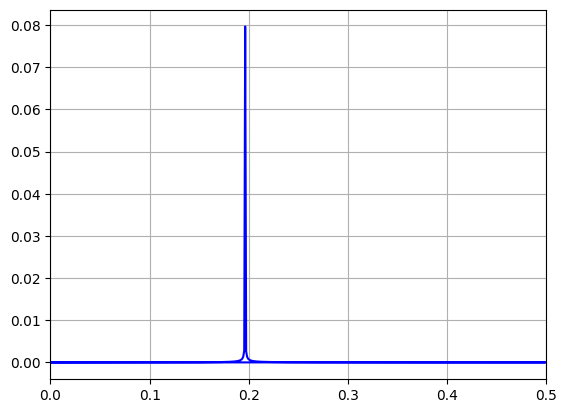

In [45]:
myAmplitude=np.abs(np.fft.fft(myParticle.x.flatten())); #use Fast Fourier Transform (FFT) to measure tune
myTunes=np.fft.fftfreq(n_turns)

plt.plot(myTunes,myAmplitude, 'b')
plt.xlim([0,0.5])
plt.grid()

In [46]:
myTunes[np.argmax(myAmplitude)] #select maximum

np.float64(0.1962890625)

In [47]:
#to compare with
np.round(myTwiss.qx)-myTwiss.qx #subtract integer part of tune

np.float64(0.1962557258086588)

In general we can use in our frequency analysis the fact that we expect to have well separated harmonic oscillations and they are time-constant.

The NAFF algorithm of J. Laskar can be used as an alternative for the FFT. A python library with an implementation of the algorithm is found in https://pypi.org/project/nafflib/ - how does it compare to the FFT for tune computation?

In [48]:
import nafflib
import numpy as np

t = np.linspace(1, 1024, num=1024, endpoint=True)
signal = myParticle.x.flatten()
# outputs an array of arrays for each frequency. Each sub-array includes:
# [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

myListNAFF=[]
myListFFT=[]
for i in np.arange(10,1025):
    myListNAFF.append(nafflib.tune(signal[0:i]))
    myAmplitude=np.abs(np.fft.fft(signal[0:i]));
    myTunes=np.linspace(0,1,i)
    myListFFT.append(np.min(myTunes[myAmplitude==np.max(myAmplitude)]))

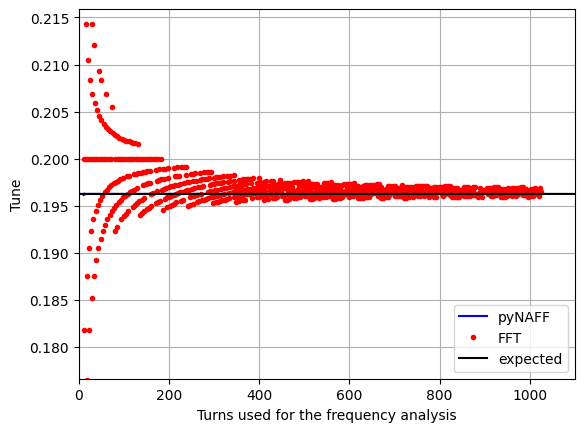

In [49]:
Qx = np.round(myTwiss.qx)-myTwiss.qx
myFig=plt.figure()
plt.plot(np.arange(10,1025),myListNAFF,'b',label='pyNAFF')
plt.plot(np.arange(10,1025),myListFFT,'.r',label='FFT')
plt.plot(np.arange(0,2000),3-myTwiss.qx+np.arange(0,2000)*0,'k',label='expected')
plt.grid()
plt.ylim(Qx*0.9,Qx*1.1)
plt.xlim(0,1100)
plt.xlabel('Turns used for the frequency analysis')
plt.ylabel('Tune')
plt.legend(loc='best')

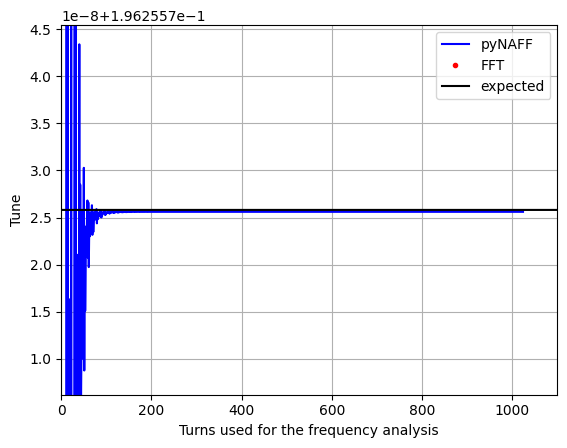

In [50]:
myFig.gca().set_ylim(Qx*0.9999999,Qx*1.0000001)
display(myFig)

## What happens in a coupled system...?

Let's use line2 from earlier, which has a skew quadrupole error. 

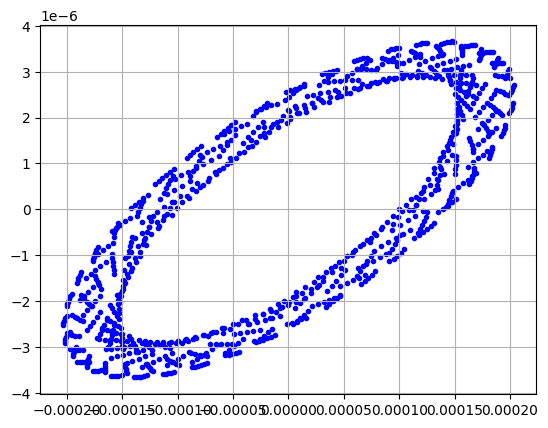

In [51]:
env.vars['kick_strength'] = 0.00
env.vars['kskew'] = 0.007 #make the skew error super strong to exaggerate effects

particles = line2.build_particles(
                        x=0.0001) #generate single particle

n_turns = 2**10
line2.track(particles, num_turns=n_turns,
              turn_by_turn_monitor= True) #track for large number of turns and save position at same point each turn
myParticle = line2.record_last_track
plt.scatter(myParticle.x.T, myParticle.px.T, marker = '.', color = 'b') #plot phase space ellipse from tracking over successive turns
plt.grid()

In [52]:
myTwiss_c = line2.twiss4d()

Let's try and compute the invariants of the system. 

In [53]:
x = myParticle.x.flatten()
px = myParticle.px.flatten()
cs = myTwiss_c.gamx[0]*x**2 + 2*myTwiss_c.alfx[0]*px*x + myTwiss_c.betx[0]*px**2

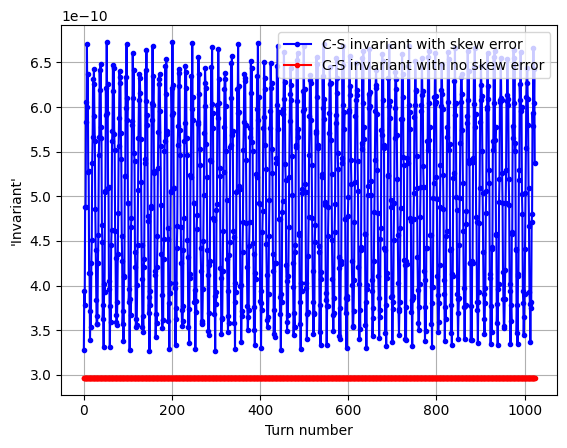

In [54]:
plt.plot(myParticle.at_turn.flatten(), cs, '.-b', label = 'C-S invariant with skew error') 
plt.plot(cs_2d, '.-r', label = 'C-S invariant with no skew error')
plt.ylabel("\'Invariant\'")
plt.xlabel('Turn number')
plt.legend()
plt.grid()

Is this still an invariant of the system?

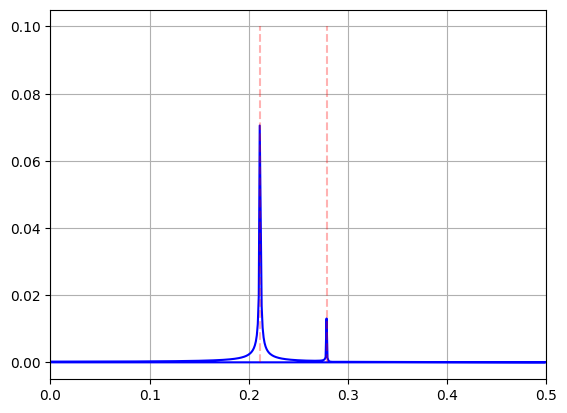

In [55]:
myAmplitude=np.abs(np.fft.fft(x)); #use Fast Fourier Transform (FFT) to measure tune
myTunes=np.fft.fftfreq(n_turns)

peaks = scipy.signal.find_peaks(myAmplitude, height = 0.01)[0]

plt.plot(myTunes,myAmplitude, 'b')
plt.xlim([0,0.5])
plt.grid()
plt.vlines(myTunes[peaks], 0, 0.1, color = 'r', linestyle = '--', alpha = 0.3)

Why are there 2 peaks?

In [56]:
rmat = myTwiss_c.get_R_matrix('_start_point.line2', '_end_point')
rmat4 = rmat[:4,:4] #take 4d part only
display(rmat4)

array([[ 1.45898665e+00, -7.72982839e+01, -5.41087988e-01,
        -2.11714134e-09],
       [ 2.79683568e-02, -7.96378762e-01, -5.57465133e-03,
        -4.77429388e-11],
       [ 3.40962336e-01,  1.62767224e-10,  4.71540220e-01,
         4.87089052e+01],
       [-7.05685252e-03, -3.47967579e-12, -3.02895326e-02,
        -1.00812179e+00]])

In [57]:
eigtunes = np.angle(np.linalg.eig(rmat4)[0])/np.pi/2
eigtunes, myTunes[peaks]

(array([ 0.21131389, -0.21131389,  0.27842835, -0.27842835]),
 array([ 0.2109375 ,  0.27832031, -0.27832031, -0.2109375 ]))

The two peaks we measure from tracking match to the tunes from the eigenvalues of the 4d transfer matrix.

In coupled systems we cannot consider horizontal and vertical separately! The 4d system must be considered as a whole. However, there are still many things we can do to make things more intuitive. We can show that the system has two orthogonal eigenmodes - this is why we still obtain two tunes from the transfer matrix. However, these tunes and modes of oscillation no longer correspond to purely horizontal and vertical motion; for the tunes of a coupled system we can denote them as $q_u$ and $q_v$.

In linear systems, it is still possible to diagonalise the transfer matrix (this is a property of any symplectic matrix). Xsuite enables us to do this using the W-matrix, which transforms from a normalised decoupled space back to our conventional transverse phase space. As such:

In [58]:
X = np.vstack([myParticle.x.flatten(), myParticle.px.flatten(), myParticle.y, myParticle.py, myParticle.zeta, myParticle.delta]).T
Xnorm = []
wmat = np.linalg.inv(myTwiss_c.W_matrix[0])

for Xl in X: #use Xsuite's calculation of the W matrix -- this is a powerful tool...
    Xnorm.append(wmat@Xl)

Xnorm = np.vstack(Xnorm)

[ 1.00000000e-04  1.45898619e-04 -2.17758115e-05 ... -1.38865191e-04
  1.13188581e-04  1.72474434e-04]


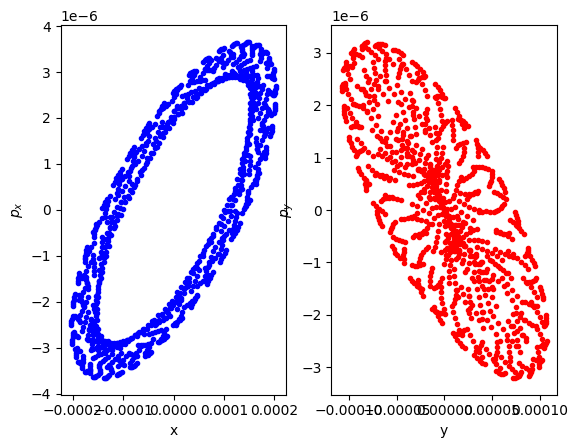

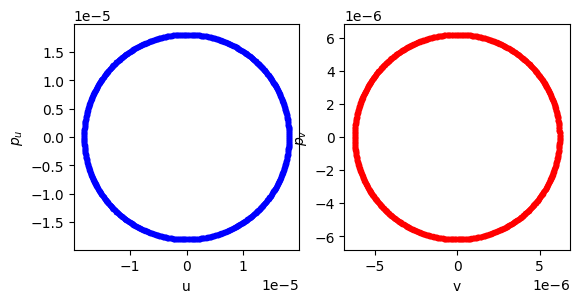

In [59]:
print(X[:,0])
plt.subplot(121)
plt.plot(X[:,0],X[:,1], '.b')
plt.xlabel('x')
plt.ylabel(r'$p_x$')
plt.subplot(122)
plt.plot(X[:,2],X[:,3], '.r')
plt.xlabel('y')
plt.ylabel(r'$p_y$')
plt.figure()
plt.subplot(121)
plt.plot(Xnorm[:,0],Xnorm[:,1], '.b')
plt.xlabel('u')
plt.ylabel(r'$p_u$')
plt.gca().set_aspect('equal')
plt.subplot(122)
plt.plot(Xnorm[:,2],Xnorm[:,3], '.r')
plt.xlabel('v')
plt.ylabel(r'$p_v$')
plt.gca().set_aspect('equal')